In [2]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
import os
import albumentations as A
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random
import subprocess
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Get Train Labels csv

In [3]:
df = pd.read_csv('../Labels/AllLabels.csv')
df.head()
print(df.shape)

(8925, 5)


In [4]:
# Cargar Labels del CSV
def load_labels(csv_path):
    df = pd.read_csv(csv_path)
    labels_dict = {}
    for _, row in df.iterrows():
        clip_id = row['ClipID'].replace('.avi', '').replace('.mp4', '')
        labels_dict[clip_id] = [row['Boredom'], row['Engagement'], row['Confusion'], row['Frustration']]
    return labels_dict

In [5]:
# Procesar dataset
def process_dataset(frames_root_folder):
    frames_root_folder = Path(frames_root_folder)
    video_folders = list(frames_root_folder.glob("*/*"))
    with open("video_folders.txt", "w") as f:
        for folder in video_folders:
            folder = str(folder).split("\\")[-1]
            f.write(str(folder) + "\n")

In [9]:
frames_root = "output_frames/Train"
process_dataset(frames_root)

In [10]:
# Load the text file with ClipIDs
with open("video_folders.txt", "r") as f:
    clip_ids = [line.strip() for line in f]
df['ClipID'] = df['ClipID'].str.replace('.avi', '').str.replace('.mp4', '')
filtered_df = df[df['ClipID'].isin(clip_ids)]
filtered_df.shape

(5481, 5)

In [ ]:
# save filtered_df to a csv file
filtered_df.to_csv("../Labels/TrainLabels.csv", index=False)

# 2. Get Frames per Video

In [23]:
def extract_frames_from_video(video_path, output_folder, max_frames=None):
    cap = cv2.VideoCapture(str(video_path))
    frame_count = 0
    success, frame = cap.read()
    
    while success:
        if max_frames and frame_count >= max_frames:
            break
        frame_filename = output_folder / f"frame_{frame_count:04d}.jpg"
        cv2.imwrite(str(frame_filename), frame)
        success, frame = cap.read()
        frame_count += 1
    cap.release()

def get_all_video_paths(dataset_dir, subset="Train"):
    dataset_path = Path(dataset_dir) / subset
    video_paths = []
    for person_folder in dataset_path.iterdir():
        if person_folder.is_dir():
            for video_folder in person_folder.iterdir():
                if video_folder.is_dir():
                    for video_file in video_folder.glob("*.*"):
                        if video_file.suffix.lower() in [".avi", ".mp4"]:
                            video_paths.append(video_file)

    return video_paths

def getFramesPerVideo(dataset_dir, subset="Train",max_frames_per_video=None, output_base="output_frames"):
    video_paths = get_all_video_paths(dataset_dir, subset=subset)
    print(f"Procesando {len(video_paths)} videos del conjunto {subset}...")

    for video_path in tqdm(video_paths, desc="Extrayendo frames"):
        relative_path = video_path.relative_to(dataset_dir)
        output_folder = Path(output_base) / relative_path.parent
        output_folder.mkdir(parents=True, exist_ok=True)
        extract_frames_from_video(video_path, output_folder, max_frames=max_frames_per_video)

In [24]:
subset = "Train"  # Cambia a "Test" o "Validation" según sea necesario
getFramesPerVideo(
    dataset_dir="../Datasets/DaiSee/DAiSEE/DataSet/",          # Ruta raíz al dataset DAiSEE
    subset=subset,
    #max_videos=6000,             # Cuántos videos procesar
    max_frames_per_video=75,       # Frames máximos por video (None = todos)
    output_base="output_frames"   # Carpeta donde guardar los frames extraídos
)

Procesando 5481 videos del conjunto Train...


Extrayendo frames: 100%|██████████| 5481/5481 [1:03:58<00:00,  1.43it/s]


# 3. Only Engagement Level

In [26]:
df_train = pd.read_csv("../Labels/TrainLabels.csv")
print(df_train.head())
print(df_train.shape)

       ClipID  Boredom  Engagement  Confusion  Frustration
0  1100011002        0           2          0            0
1  1100011003        0           2          0            0
2  1100011004        0           3          0            0
3  1100011005        0           3          0            0
4  1100011006        0           3          0            0
(5481, 5)


In [27]:
# Filtra los ClipIDs con engagement == 0
df_train_filtered = df_train.drop(columns=["Boredom", "Confusion", "Frustration"])
df_train_filtered['Engagement'] = df_train_filtered['Engagement'].replace({0: 0, 1: 0, 2: 1, 3: 1})
df_train_filtered = df_train_filtered[df_train_filtered['Engagement'] == 0]

# Set con los ClipID válidos
valid_clip_ids = set(df_train_filtered['ClipID'].astype(str))
valid_clip_ids

{'1100021003',
 '1100021055',
 '1100022005',
 '1100042023',
 '1100042026',
 '1100051007',
 '1100051016',
 '1100051030',
 '1100051031',
 '1100051053',
 '1100052014',
 '1100062008',
 '1100062045',
 '1100062049',
 '1100112002',
 '1100112006',
 '1100122056',
 '1100131017',
 '1100141013',
 '1100141027',
 '1100142033',
 '1100151011',
 '1100151057',
 '1100152010',
 '1100152017',
 '1100152031',
 '1100152055',
 '1100152070',
 '1100161053',
 '1100162005',
 '1100162016',
 '1100171004',
 '1100171008',
 '1100171059',
 '1100172012',
 '1100172017',
 '1100172033',
 '1100172034',
 '1100172043',
 '1100172058',
 '1100412018',
 '1100412033',
 '1100412039',
 '1110031010',
 '1110031025',
 '1110031027',
 '1110031033',
 '1110031038',
 '1110031056',
 '1110031063',
 '1110032014',
 '1110032027',
 '1110032043',
 '1813740138',
 '1813740184',
 '1813740185',
 '2000491077',
 '2000501006',
 '2000501030',
 '2000502053',
 '2000502065',
 '2000502081',
 '2026140257',
 '2026140264',
 '2026140273',
 '2056010134',
 '20560102

In [32]:
len(valid_clip_ids)

248

In [28]:
from pathlib import Path
import cv2
from tqdm import tqdm

def extract_frames_from_video(video_path, output_folder, max_frames=None):
    cap = cv2.VideoCapture(str(video_path))
    frame_count = 0
    success, frame = cap.read()
    
    while success:
        if max_frames and frame_count >= max_frames:
            break
        frame_filename = output_folder / f"frame_{frame_count:04d}.jpg"
        cv2.imwrite(str(frame_filename), frame)
        success, frame = cap.read()
        frame_count += 1
    cap.release()

def get_all_video_paths(dataset_dir, subset="Train"):
    dataset_path = Path(dataset_dir) / subset
    video_paths = []
    for person_folder in dataset_path.iterdir():
        if person_folder.is_dir():
            for video_folder in person_folder.iterdir():
                if video_folder.is_dir():
                    for video_file in video_folder.glob("*.*"):
                        if video_file.suffix.lower() in [".avi", ".mp4"]:
                            video_paths.append(video_file)
    return video_paths

def getFramesPerVideo_filtered(dataset_dir, valid_clip_ids, subset="Train", max_frames_per_video=None, output_base="Train_Augmentation"):
    video_paths = get_all_video_paths(dataset_dir, subset=subset)
    print(f"Procesando {len(video_paths)} videos del conjunto {subset}...")

    for video_path in tqdm(video_paths, desc="Extrayendo frames"):
        relative_path = video_path.relative_to(dataset_dir)
        person_id = relative_path.parts[1]  # e.g. Train/person123
        clip_id = relative_path.parts[2]    # clip_id (última carpeta antes del video)

        if clip_id in valid_clip_ids:
            # Genera el nuevo path: Train_Augmentation/person_id/clip_id/frames
            output_folder = Path(output_base) / person_id / clip_id
            output_folder.mkdir(parents=True, exist_ok=True)
            extract_frames_from_video(video_path, output_folder, max_frames=max_frames_per_video)

In [31]:
getFramesPerVideo_filtered(
    dataset_dir="../../Datasets/DaiSee/DAiSEE/DataSet/",
    valid_clip_ids=valid_clip_ids,
    subset="Train",
    max_frames_per_video=5,  # o el número que necesites
    output_base="../output_frames/Train_Augmentation"
)

Procesando 5481 videos del conjunto Train...


Extrayendo frames: 100%|██████████| 5481/5481 [00:05<00:00, 1043.77it/s]


## Data Augmentation

In [ ]:
# Define las transformaciones
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.GaussianBlur(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.RandomScale(scale_limit=0.1, p=0.5),
    A.GaussNoise(p=0.3),
])

def augment_and_save_images(input_dir, output_dir, augment_times=5):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for img_name in os.listdir(input_dir):
        if img_name.lower().endswith(".jpg"):
            img_path = input_dir / img_name
            image = cv2.imread(str(img_path))

            for i in range(augment_times):
                augmented = augmentations(image=image)["image"]
                aug_filename = output_dir / f"{img_name[:-4]}_aug{i}.jpg"
                cv2.imwrite(str(aug_filename), augmented)


In [ ]:
from deepface import DeepFace
def load_labels(csv_path):
    df = pd.read_csv(csv_path)
    labels_dict = {}
    for _, row in df.iterrows():
        # Convertir ClipID a str antes de usar replace y luego a int
        clip_id = str(row['ClipID']).replace('.avi', '').replace('.mp4', '')
        labels_dict[clip_id] = [
            int(row['Boredom']),
            int(row['Engagement']),
            int(row['Confusion']),
            int(row['Frustration'])
        ]
    return labels_dict

In [34]:
def extract_facenet_embedding(img_path):
    try:
        embedding = DeepFace.represent(img_path=img_path, model_name='Facenet', enforce_detection=False)
        return np.array(embedding[0]['embedding'])
    except Exception as e:
        print(f"Error en {img_path}: {e}")
        return None

In [35]:
def process_dataset(frames_root_folder, labels_csv, max_videos=1250):
    labels = load_labels(labels_csv)
    X = []
    y = []

    # Obtener todas las carpetas de video
    frames_root_folder = Path(frames_root_folder)
    video_folders = list(frames_root_folder.glob("*/*"))
    print(f"Total de carpetas de video encontradas: {len(video_folders)}")

    # Limitar a los primeros `max_videos`
    video_folders = video_folders[:max_videos]
    print(f"Procesando {len(video_folders)} carpetas de video...")

    # Procesar cada carpeta de video
    for video_folder in tqdm(video_folders, desc="Procesando videos"):
        clip_id = video_folder.name

        # Verificar si el clip_id está en labels
        if clip_id not in labels:
            with open("missing_clip_ids.txt", "a") as f:
                f.write(clip_id + "\n")
            print(f"ClipID {clip_id} no encontrado en labels.")
            continue

        emotion_levels = labels[clip_id]  # lista de 4 números

        # Crear un vector one-hot de 16 posiciones
        label_vector = np.zeros(16)
        for i, level in enumerate(emotion_levels):  # i = 0 (boredom), 1 (engagement), 2 (confusion), 3 (frustration)
            index = i * 4 + level  # cada emoción tiene 4 niveles
            label_vector[index] = 1

        video_embeddings = []
        
        # Procesar los frames dentro de esta carpeta
        for frame_path in video_folder.glob("*.jpg"):
            embedding = extract_facenet_embedding(str(frame_path))
            if embedding is not None:
                video_embeddings.append(embedding)
        
        video_embedding = np.mean(video_embeddings, axis=0)
        video_embedding = np.array(video_embedding)
        
        X.append(video_embedding)
        y.append(label_vector)

    X = np.array(X)
    y = np.array(y)

    print(f"Dataset procesado: {X.shape[0]} ejemplos.")
    return X, y

In [41]:
# Procesar train dataset
frames_root = "../output_frames/Train_Augmentation"
labels_csv = "../Labels/TrainLabels.csv" 
X_train_Augmentation, X_train_Augmentation = process_dataset(frames_root, labels_csv)

Total de carpetas de video encontradas: 248
Procesando 248 carpetas de video...


Procesando videos:  10%|█         | 25/248 [00:44<06:37,  1.78s/it]


KeyboardInterrupt: 

# 4. Data Selection

In [3]:
# For each student, view the quantity of videos per engagement level in a dataframe.
df_train = pd.read_csv("../Labels/AllLabels.csv")
df_train['StudentID'] = df_train['ClipID'].astype(str).str[:6]
engagement_student = df_train.pivot_table(index='StudentID', columns='Engagement', aggfunc='size', fill_value=0)
engagement_student.columns = [f'Engagement_{col}' for col in engagement_student.columns]  
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
display(engagement_student.T)

print(engagement_student.T.shape)

StudentID,110001,110002,110004,110005,110006,110007,110008,110010,110011,110012,110013,110014,110015,110016,110017,110041,111003,181374,200048,200049,200050,200054,202614,205601,210051,210052,210053,210055,210056,210057,210058,210059,210060,210061,226051,240846,248510,290428,303830,310062,310063,310064,310066,310068,310069,310070,310071,310072,310073,310074,310075,310076,310077,310078,310079,310080,310081,310082,310083,334463,337021,342227,350361,400018,400022,400023,400030,400033,401835,410019,410020,410024,410025,410026,410027,410028,410029,410030,410032,411021,411031,414081,459999,500039,500043,500044,500067,500095,510009,510034,510035,510036,510037,510038,510040,510042,510045,510046,510047,522129,556463,567496,591292,769862,799402,826382,826412,882654,907001,928901,940328,987736
Engagement_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,1,3,1,0,0,0,0,0,1,0,0,1,1,0,0,7,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,6,0,0,0,0,1,0,1,0,5,0,0,3,1,1,1,1,0,1,0,6,0,4,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,1
Engagement_1,0,3,2,6,3,0,0,0,2,1,0,3,6,3,7,2,7,2,0,1,5,0,3,1,3,1,2,6,2,10,4,1,2,2,3,2,0,2,5,1,0,8,1,4,1,3,0,1,0,2,13,7,3,4,2,0,1,7,0,5,0,3,2,3,4,1,10,1,2,10,7,9,21,12,3,7,16,8,7,23,7,6,2,8,0,3,8,7,1,7,7,0,0,0,7,0,1,2,2,1,14,4,1,3,13,1,24,1,2,5,1,3
Engagement_2,12,17,22,68,44,100,5,1,38,38,1,61,51,18,50,15,38,45,20,10,61,51,25,43,38,81,55,73,36,72,58,49,69,51,46,47,16,25,30,32,27,32,31,10,30,51,7,33,25,50,69,26,65,38,59,1,32,23,17,57,17,34,29,75,40,32,32,63,30,61,52,44,66,60,15,53,79,14,35,67,28,28,20,73,6,71,74,71,39,41,51,4,12,61,74,75,30,81,53,26,37,29,23,22,37,39,32,23,10,24,23,12
Engagement_3,102,21,10,19,32,42,4,0,35,48,6,25,20,10,19,11,20,64,11,3,43,38,49,43,49,29,69,41,47,36,30,74,49,70,46,40,64,66,47,53,43,13,13,5,7,29,2,79,21,55,25,10,46,74,26,2,13,19,12,46,73,60,81,40,15,21,15,44,51,15,45,14,24,12,11,13,23,7,26,18,18,77,60,27,7,45,44,34,44,32,25,2,19,63,31,54,57,39,28,82,43,45,59,65,55,39,27,67,43,55,43,25


(4, 112)


In [4]:
# Logic to select the same quantity of videos per engagement level, with a maximum of 61 videos per engagement level.
root_dir = "../Daisee/DataSet/Train/"
max_per_engagement = 61
df_train['VideoFolderID'] = df_train['ClipID'].astype(str)
grouped = df_train.groupby('StudentID')
final_selection = []


global_engagement_counts = {0: 0, 1: 0, 2: 0, 3: 0}
used_engagement_by_student = {}
student_video_counts = {}

# Lista aleatoria de estudiantes válidos
students_list = [s for s in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, s)) and s in grouped.groups]
random.shuffle(students_list)

# Paso 1: seleccionar todos los de engagement 0
for student_id in students_list:
    student_videos = grouped.get_group(student_id)
    engagement_0 = student_videos[student_videos['Engagement'] == 0]

    for _, row in engagement_0.iterrows():
        final_selection.append({
            'StudentID': student_id,
            'VideoFolderID': row['VideoFolderID'],
            'Engagement': 0
        })
        global_engagement_counts[0] += 1
        used_engagement_by_student.setdefault(student_id, set()).add(0)
        student_video_counts[student_id] = student_video_counts.get(student_id, 0) + 1

# Paso 2: para engagement 1, luego 2, luego 3 — solo estudiantes aún no usados
for eng_level in [1, 2, 3]:
    for student_id in students_list:
        if global_engagement_counts[eng_level] >= max_per_engagement:
            break

        if student_video_counts.get(student_id, 0) > 0:
            continue  # Este estudiante ya tiene algún video seleccionado

        student_videos = grouped.get_group(student_id)
        eng_subset = student_videos[student_videos['Engagement'] == eng_level]

        if not eng_subset.empty:
            row = eng_subset.sample(1).iloc[0]
            final_selection.append({
                'StudentID': student_id,
                'VideoFolderID': row['VideoFolderID'],
                'Engagement': eng_level
            })
            global_engagement_counts[eng_level] += 1
            used_engagement_by_student.setdefault(student_id, set()).add(eng_level)
            student_video_counts[student_id] = 1

# Paso 3: completar faltantes (hasta 2 videos por estudiante)
for eng_level in [1, 2, 3]:
    if global_engagement_counts[eng_level] >= max_per_engagement:
        continue

    remaining_videos = df_train[df_train['Engagement'] == eng_level].sample(frac=1, random_state=42)

    for _, row in remaining_videos.iterrows():
        if global_engagement_counts[eng_level] >= max_per_engagement:
            break

        student_id = row['StudentID']
        if student_video_counts.get(student_id, 0) >= 2:
            continue  # Ya tiene 2 videos

        if eng_level in used_engagement_by_student.get(student_id, set()):
            continue  # Ya se usó este nivel en este estudiante

        final_selection.append({
            'StudentID': student_id,
            'VideoFolderID': row['VideoFolderID'],
            'Engagement': eng_level
        })
        global_engagement_counts[eng_level] += 1
        used_engagement_by_student.setdefault(student_id, set()).add(eng_level)
        student_video_counts[student_id] = student_video_counts.get(student_id, 0) + 1

# Paso 4: si sigue faltando, permitir hasta 3 videos por estudiante
for eng_level in [1, 2, 3]:
    if global_engagement_counts[eng_level] >= max_per_engagement:
        continue

    remaining_videos = df_train[df_train['Engagement'] == eng_level].sample(frac=1, random_state=99)

    for _, row in remaining_videos.iterrows():
        if global_engagement_counts[eng_level] >= max_per_engagement:
            break

        student_id = row['StudentID']
        if student_video_counts.get(student_id, 0) >= 3:
            continue

        if eng_level in used_engagement_by_student.get(student_id, set()):
            continue

        final_selection.append({
            'StudentID': student_id,
            'VideoFolderID': row['VideoFolderID'],
            'Engagement': eng_level
        })
        global_engagement_counts[eng_level] += 1
        used_engagement_by_student.setdefault(student_id, set()).add(eng_level)
        student_video_counts[student_id] = student_video_counts.get(student_id, 0) + 1

df_selected_videos = pd.DataFrame(final_selection)
print(df_selected_videos.head())
print(f"\nTotal estudiantes seleccionados: {df_selected_videos['StudentID'].nunique()}")
print(f"Cantidad total de videos seleccionados: {df_selected_videos.shape[0]}")
print("\nDistribución por engagement:")
print(df_selected_videos['Engagement'].value_counts())

  StudentID   VideoFolderID  Engagement
0    410028  4100281067.avi           0
1    410024  4100242032.avi           0
2    310075  3100751007.avi           0
3    310075  3100751010.avi           0
4    110041  1100412018.avi           0

Total estudiantes seleccionados: 112
Cantidad total de videos seleccionados: 244

Distribución por engagement:
Engagement
0    61
1    61
2    61
3    61
Name: count, dtype: int64


In [5]:
# View distribution of engagement levels for each student to check if the selection is balanced
pivot_table = df_selected_videos.pivot_table(index='StudentID', columns='Engagement', aggfunc='size', fill_value=0)
pivot_table.columns = [f'Engagement_{col}' for col in pivot_table.columns]  
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
display(pivot_table.T)
print(pivot_table.T.shape)

StudentID,110001,110002,110004,110005,110006,110007,110008,110010,110011,110012,110013,110014,110015,110016,110017,110041,111003,181374,200048,200049,200050,200054,202614,205601,210051,210052,210053,210055,210056,210057,210058,210059,210060,210061,226051,240846,248510,290428,303830,310062,310063,310064,310066,310068,310069,310070,310071,310072,310073,310074,310075,310076,310077,310078,310079,310080,310081,310082,310083,334463,337021,342227,350361,400018,400022,400023,400030,400033,401835,410019,410020,410024,410025,410026,410027,410028,410029,410030,410032,411021,411031,414081,459999,500039,500043,500044,500067,500095,510009,510034,510035,510036,510037,510038,510040,510042,510045,510046,510047,522129,556463,567496,591292,769862,799402,826382,826412,882654,907001,928901,940328,987736
Engagement_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,1,3,1,0,0,0,0,0,1,0,0,1,1,0,0,7,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,6,0,0,0,0,1,0,1,0,5,0,0,3,1,1,1,1,0,1,0,6,0,4,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,1
Engagement_1,0,1,1,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,1,0,1,0,1,1,0,0,1,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,0,1,0,1,0,1,1,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,0,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0
Engagement_2,1,0,0,1,0,1,1,1,1,1,0,0,1,1,0,0,0,1,1,0,1,1,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,1,1,1,0,0,0,1,0,1,0,0,1,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,0,1,0,0,0
Engagement_3,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,0,1,1,0,1,1,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,1,1,0,0,0,1,0,1,1,1,0,1,1,0,1,0,1,1,1,1,0,0,0,1,0,1,1,1


(4, 112)


Se seleccionaron todos los videos con Engagement 0, ya que es el nivel con la menor cantidad de videos, asegurando que cada estudiante tenga al menos un video seleccionado. Luego, se seleccionaron videos aleatoriamente de los niveles de Engagement 1, 2 y 3, distribuyéndolos de forma equilibrada, y asegurando que cada estudiante tuviera un máximo de 3 videos seleccionados en total. Este proceso garantiza una distribución balanceada de los niveles de Engagement entre los estudiantes, sin exceder el límite máximo de 61 videos por nivel.

# 5. Select features of frames with OpenFace

In [3]:
df_selected_videos = pd.read_csv("../save_model/df_selected_videos.csv")
print(df_selected_videos)
print(df_selected_videos.shape)

     StudentID   VideoFolderID  Engagement     VideoID
0       410028  4100281067.avi           0  4100281067
1       410024  4100242032.avi           0  4100242032
2       310075  3100751007.avi           0  3100751007
3       310075  3100751010.avi           0  3100751010
4       110041  1100412018.avi           0  1100412018
..         ...             ...         ...         ...
239     310076  3100761063.avi           3  3100761063
240     410027  4100272036.avi           3  4100272036
241     310080  3100802001.avi           3  3100802001
242     310071  3100711051.avi           3  3100711051
243     567496  5674960279.avi           3  5674960279

[244 rows x 4 columns]
(244, 4)


In [ ]:
# Extract feature with OpenFace in csv format and delete txt details
video_base_path = r"D:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\src\sagemaker\Daisee\DataSet\Train"
output_path = r"D:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\src\sagemaker\features"
exe_path = r"D:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\src\sagemaker\OpenFace_2.2.0_win_x64\FeatureExtraction.exe"

for _, row in df_selected_videos.iterrows():
    student_id = str(row['StudentID'])
    video_filename = row['VideoFolderID']
    video_name = os.path.splitext(video_filename)[0]  # Quita ".avi", queda "4100281001"

    video_path = os.path.join(video_base_path, student_id, video_name, video_filename)

    if not os.path.exists(video_path):
        print(f"No encontrado: {video_path}")
        continue

    command = [
        exe_path,
        "-f", f'"{video_path}"',
        "-out_dir", f'"{output_path}"',
        "-pose", "-aus", "-gaze", "-2Dfp", "-3Dfp", "-pdmparams", "-nobadaligned"
    ]

    print("Ejecutando:", " ".join(command))

    try:
        subprocess.run(" ".join(command), check=True)

        # Eliminar el archivo *_of_details.txt si fue creado
        txt_path = os.path.join(output_path, f"{video_name}_of_details.txt")
        if os.path.exists(txt_path):
            os.remove(txt_path)
            print(f"Eliminado: {txt_path}")

    except subprocess.CalledProcessError as e:
        print(f"Error procesando {video_filename}: {e}")


Ejecutando: D:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\src\sagemaker\OpenFace_2.2.0_win_x64\FeatureExtraction.exe -f "D:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\src\sagemaker\Daisee\DataSet\Train\410028\4100281067\4100281067.avi" -out_dir "D:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\src\sagemaker\features" -pose -aus -gaze -2Dfp -3Dfp -pdmparams -nobadaligned
Eliminado: D:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\src\sagemaker\features\4100281067_of_details.txt
Ejecutando: D:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\src\sagemaker\OpenFace_2.2.0_win_x64\FeatureExtraction.exe -f "D:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\src\sagemaker\Daisee\DataSet\Train\410024\4100242032\4100242032.avi" -out_dir "D:\OneDrive - Universidad Peruana de Ciencias\Documents\

In [28]:
# For each excel verify is some row has less than 70% of confidence and show
features_dir = "../features/"
video_features = []
video_ids = []
rare_videos = []

for file in os.listdir(features_dir):
    if file.endswith(".csv") or file.endswith(".txt") or file.endswith(".xls") or file.endswith(".xlsx"):
        df = pd.read_csv(os.path.join(features_dir, file))
        video_name = os.path.splitext(file)[0]
        
        # Verifica si hay alguna fila con menos del 70% de confianza
        if df[' confidence'].min() < 0.7:
            rare_videos.append(video_name)
            print(f"El video {video_name} tiene filas con menos del 70% de confianza.")
        
        n_samples, n_features = df.shape
        if n_samples < 300:
            rare_videos.append(video_name)
            print(f"El video {video_name} tiene menos de 300 frames: {n_samples} frames.")
            
        if n_samples > 300:
            rare_videos.append(video_name)
            print(f"El video {video_name} tiene más de 300 frames: {n_samples} frames.")

print(rare_videos)

El video 29042801370 tiene más de 300 frames: 302 frames.
El video 29042801630 tiene más de 300 frames: 302 frames.
El video 33702102190 tiene más de 300 frames: 302 frames.
El video 33702102640 tiene más de 300 frames: 314 frames.
El video 79940201100 tiene más de 300 frames: 314 frames.
El video 79940202800 tiene más de 300 frames: 314 frames.
El video 88265401690 tiene más de 300 frames: 302 frames.
El video 88265401750 tiene más de 300 frames: 302 frames.
El video 907001270 tiene más de 300 frames: 302 frames.
El video 907001950 tiene más de 300 frames: 302 frames.
['29042801370', '29042801630', '33702102190', '33702102640', '79940201100', '79940202800', '88265401690', '88265401750', '907001270', '907001950']


In [10]:
# Delete the videos with less than 70% of confidence and less than 300 frames
df_selected_videos = df_selected_videos[~df_selected_videos['VideoFolderID'].isin(['5674960283.avi', '8264120240.avi', '5221290280.avi'])]
df_selected_videos.shape

(241, 4)

In [11]:
# Visualize the characteristics of each frame of the video 
testing = pd.read_csv("../features/1100012016.csv")
testing

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,1,0,0.000,0.98,1,0.041183,-0.069217,-0.996751,-0.128286,-0.074051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,0.033,0.98,1,0.047542,-0.052776,-0.997474,-0.145730,-0.074598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,0.067,0.98,1,0.062618,-0.045656,-0.996993,-0.126326,-0.088174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0.100,0.98,1,0.064949,-0.041252,-0.997036,-0.131296,-0.078474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,0.133,0.98,1,0.051563,-0.042792,-0.997752,-0.124661,-0.065538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,0,9.833,0.98,1,0.100576,-0.020195,-0.994724,-0.092224,-0.069746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,297,0,9.867,0.98,1,0.115113,-0.023966,-0.993063,-0.077843,-0.071681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,298,0,9.900,0.98,1,0.108734,-0.025822,-0.993735,-0.076312,-0.069229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,299,0,9.933,0.98,1,0.102783,-0.033252,-0.994148,-0.075242,-0.071810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Verify the names of the columns of the csv file
testing.columns

Index(['frame', ' face_id', ' timestamp', ' confidence', ' success',
       ' gaze_0_x', ' gaze_0_y', ' gaze_0_z', ' gaze_1_x', ' gaze_1_y',
       ...
       ' AU12_c', ' AU14_c', ' AU15_c', ' AU17_c', ' AU20_c', ' AU23_c',
       ' AU25_c', ' AU26_c', ' AU28_c', ' AU45_c'],
      dtype='object', length=714)

Para explicar al menos el 99.0% de la varianza, se necesitan 5 componentes.
Varianza explicada real: 99.41%


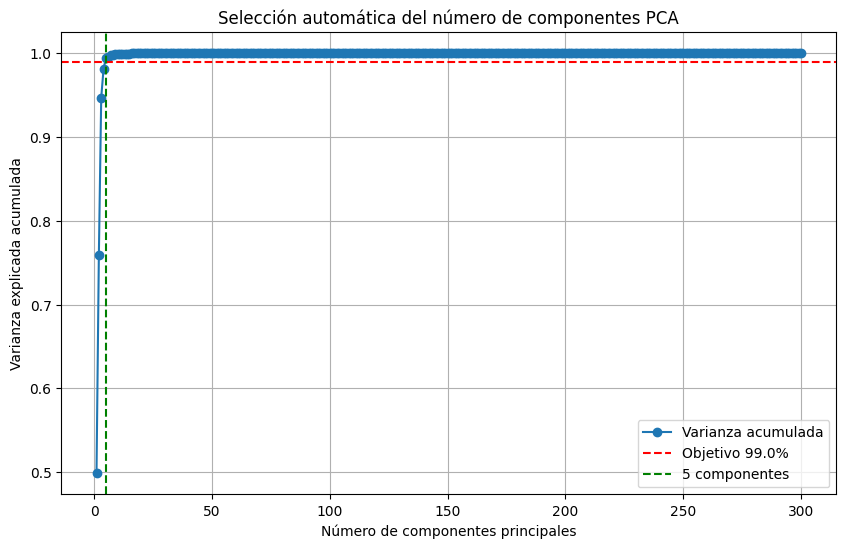

In [13]:
features_dir = "../features/"
target_variance = 0.99

# Leer un solo archivo para análisis (puedes hacer un promedio después si quieres)
file_path = os.path.join(features_dir, os.listdir(features_dir)[0])
df = pd.read_csv(file_path)

# Eliminar columnas innecesarias
columns_to_drop = ['frame', ' face_id', ' timestamp', ' confidence', ' success']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Tomar solo los primeros 300 frames
df = df.iloc[:300]

# PCA sin límite de componentes
pca = PCA()
pca.fit(df)

# Varianza explicada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Encontrar el número mínimo de componentes para explicar al menos el target_variance
n_components_target = np.argmax(cumulative_variance >= target_variance) + 1
varianza_obtenida = cumulative_variance[n_components_target - 1]

print(f"Para explicar al menos el {target_variance*100:.1f}% de la varianza, se necesitan {n_components_target} componentes.")
print(f"Varianza explicada real: {varianza_obtenida*100:.2f}%")

# Graficar
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(cumulative_variance)+1), cumulative_variance, marker='o', label='Varianza acumulada')
plt.axhline(y=target_variance, color='r', linestyle='--', label=f'Objetivo {target_variance*100:.1f}%')
plt.axvline(x=n_components_target, color='g', linestyle='--', label=f'{n_components_target} componentes')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Selección automática del número de componentes PCA')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# PCA for each frame of the videos
features_dir = "../features/"
video_features = {}
video_ids = []

for file in os.listdir(features_dir):
    if file.endswith(".csv") or file.endswith(".txt") or file.endswith(".xls") or file.endswith(".xlsx"):
        file_path = os.path.join(features_dir, file)
        df = pd.read_csv(file_path)

        columns_to_drop = ['frame', ' face_id', ' timestamp', ' confidence', ' success']
        df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

        if df.shape[0] >= 300:
            df = df.iloc[:300]  # Tomar los primeros 300 frames

            # Aplicar PCA
            pca = PCA(n_components=30)
            reduced_matrix = pca.fit_transform(df)

            # Guardar resultados
            video_name = os.path.splitext(file)[0]
            video_features[video_name] = reduced_matrix
            video_ids.append(video_name)

print(video_features)
print(video_features[video_ids[0]].shape)  # (300, 300)

{'1100012016': array([[ 2.23836626e+01,  9.28767727e+00, -8.84742762e+01, ...,
         8.82883967e-01,  3.54452633e-01, -1.16828071e+00],
       [ 3.41221503e+01, -2.15257406e+01, -8.56138112e+01, ...,
        -1.15982148e-01,  5.01977531e-01, -3.42558907e-01],
       [ 4.64805504e+01, -5.17909218e+00, -9.05005623e+01, ...,
        -2.12201063e-02,  7.83101461e-01, -3.44382434e-01],
       ...,
       [ 1.09961791e+02,  5.43343477e+01,  6.20791438e+01, ...,
        -2.79998689e-01, -2.89747960e-01,  1.35573752e-01],
       [ 1.09495033e+02,  5.70428616e+01,  6.29326954e+01, ...,
         6.55175144e-02, -4.58502886e-01, -2.35458756e-01],
       [ 1.11073784e+02,  3.21993516e+01,  5.71373404e+01, ...,
        -1.29584433e-01,  3.77746406e-01, -1.38352138e-02]]), '1100012047': array([[ 1.92330989e+01, -3.32966524e+00, -3.48961948e+01, ...,
        -4.03295704e-01,  1.74341896e-01,  9.24481762e-02],
       [ 8.51101209e+00, -6.09654253e+00, -3.38826569e+01, ...,
        -3.91792221e-02, 

In [14]:
# SVD
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import os

# SVD para cada frame de los videos
features_dir = "../features/"
video_features = {}
video_ids = []

for file in os.listdir(features_dir):
    if file.endswith(".csv") or file.endswith(".txt") or file.endswith(".xls") or file.endswith(".xlsx"):
        file_path = os.path.join(features_dir, file)
        df = pd.read_csv(file_path)

        columns_to_drop = ['frame', ' face_id', ' timestamp', ' confidence', ' success']
        df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

        if df.shape[0] >= 300:
            df = df.iloc[:300]  # Tomar los primeros 300 frames

            # Aplicar SVD
            svd = TruncatedSVD(n_components=30, random_state=42)
            reduced_matrix = svd.fit_transform(df)

            # Guardar resultados
            video_name = os.path.splitext(file)[0]
            video_features[video_name] = reduced_matrix
            video_ids.append(video_name)

print(video_features)
print(video_features[video_ids[0]].shape)  # Debería ser (300, 30)

{'1100012016': array([[ 7.87988378e+03,  2.33896974e+01,  5.55378831e+01, ...,
         9.06634264e-01,  8.42130051e-01,  4.35448908e-01],
       [ 7.87259040e+03,  4.02418001e+01,  2.98860003e+01, ...,
        -1.21679601e-01, -1.70576158e-01,  4.86419556e-01],
       [ 7.87355646e+03,  5.09070372e+01,  4.98330825e+01, ...,
        -2.49660927e-02, -7.57857177e-02,  7.89212952e-01],
       ...,
       [ 7.95324986e+03,  8.84063776e+01,  1.06610116e+01, ...,
         1.99635265e-02, -2.62225609e-01, -3.20236137e-01],
       [ 7.95481503e+03,  8.72575356e+01,  1.20048094e+01, ...,
         1.01432634e-01,  1.00702011e-01, -4.51435913e-01],
       [ 7.93817153e+03,  9.53973871e+01, -1.29972962e+00, ...,
        -9.45322127e-02, -1.73799811e-01,  3.61333666e-01]]), '1100012047': array([[ 8.49511018e+03,  2.35325940e+01, -1.61347912e+01, ...,
         2.81052307e-01, -4.07162809e-01,  1.69946779e-01],
       [ 8.49317155e+03,  1.28030943e+01, -1.05239880e+01, ...,
        -6.76274769e-02, 

In [15]:
# Convert to tensor
tensor = np.stack([video_features[vid] for vid in video_ids])
print(tensor)
print(tensor.shape)  # (num_videos, 300, 300)

[[[ 7.87988378e+03  2.33896974e+01  5.55378831e+01 ...  9.06634264e-01
    8.42130051e-01  4.35448908e-01]
  [ 7.87259040e+03  4.02418001e+01  2.98860003e+01 ... -1.21679601e-01
   -1.70576158e-01  4.86419556e-01]
  [ 7.87355646e+03  5.09070372e+01  4.98330825e+01 ... -2.49660927e-02
   -7.57857177e-02  7.89212952e-01]
  ...
  [ 7.95324986e+03  8.84063776e+01  1.06610116e+01 ...  1.99635265e-02
   -2.62225609e-01 -3.20236137e-01]
  [ 7.95481503e+03  8.72575356e+01  1.20048094e+01 ...  1.01432634e-01
    1.00702011e-01 -4.51435913e-01]
  [ 7.93817153e+03  9.53973871e+01 -1.29972962e+00 ... -9.45322127e-02
   -1.73799811e-01  3.61333666e-01]]

 [[ 8.49511018e+03  2.35325940e+01 -1.61347912e+01 ...  2.81052307e-01
   -4.07162809e-01  1.69946779e-01]
  [ 8.49317155e+03  1.28030943e+01 -1.05239880e+01 ... -6.76274769e-02
   -2.24639735e-02 -5.98489301e-01]
  [ 8.49360052e+03  6.04215783e+00 -1.09838836e+01 ... -3.50300335e-01
    7.96120460e-02  8.98637072e-02]
  ...
  [ 8.55075416e+03  9.4

In [16]:
# MinMaxScaler for each video
normalized_features = {}
for video_id, matrix in video_features.items():
    scaler = MinMaxScaler()
    norm_matrix = scaler.fit_transform(matrix)  # Aplica min-max a cada columna del 300x300
    normalized_features[video_id] = norm_matrix
normalized_features

{'1100012016': array([[0.3059796 , 0.75275392, 0.367953  , ..., 0.93595642, 0.92428444,
         0.6844311 ],
        [0.28049222, 0.79820192, 0.31980201, ..., 0.54612971, 0.43517041,
         0.70912995],
        [0.28386819, 0.82696473, 0.35724455, ..., 0.58279314, 0.48095203,
         0.85585457],
        ...,
        [0.56236409, 0.92809573, 0.28371491, ..., 0.59982565, 0.39090581,
         0.31824873],
        [0.56783373, 0.92499745, 0.28623734, ..., 0.63071003, 0.56619159,
         0.25467325],
        [0.50967149, 0.94694961, 0.26126347, ..., 0.5564211 , 0.43361346,
         0.64851707]]),
 '1100012047': array([[0.18232001, 0.35285381, 0.65333733, ..., 0.7311024 , 0.15796667,
         0.68249701],
        [0.17350803, 0.31952976, 0.68481354, ..., 0.47775657, 0.39467842,
         0.03570009],
        [0.17545787, 0.29853141, 0.68223356, ..., 0.27237045, 0.45748753,
         0.61509064],
        ...,
        [0.43524791, 0.5721111 , 0.96790664, ..., 0.40544044, 0.41788696,
      

In [17]:
# Convert to tensor
tensor = np.stack([normalized_features[vid] for vid in video_ids])
print(tensor)
print(tensor.shape)  # (num_videos, 300, 300)

[[[0.3059796  0.75275392 0.367953   ... 0.93595642 0.92428444 0.6844311 ]
  [0.28049222 0.79820192 0.31980201 ... 0.54612971 0.43517041 0.70912995]
  [0.28386819 0.82696473 0.35724455 ... 0.58279314 0.48095203 0.85585457]
  ...
  [0.56236409 0.92809573 0.28371491 ... 0.59982565 0.39090581 0.31824873]
  [0.56783373 0.92499745 0.28623734 ... 0.63071003 0.56619159 0.25467325]
  [0.50967149 0.94694961 0.26126347 ... 0.5564211  0.43361346 0.64851707]]

 [[0.18232001 0.35285381 0.65333733 ... 0.7311024  0.15796667 0.68249701]
  [0.17350803 0.31952976 0.68481354 ... 0.47775657 0.39467842 0.03570009]
  [0.17545787 0.29853141 0.68223356 ... 0.27237045 0.45748753 0.61509064]
  ...
  [0.43524791 0.5721111  0.96790664 ... 0.40544044 0.41788696 0.41833414]
  [0.4373454  0.55648348 0.9871779  ... 0.20675989 0.42604599 0.0599447 ]
  [0.44266836 0.5411313  0.98066011 ... 0.20849293 0.60082701 0.30536525]]

 [[0.40714979 0.47016204 0.37915346 ... 0.6432675  0.7110175  0.68698332]
  [0.45042767 0.497698

In [18]:
# Asegúrate que el video_id de df_selected_videos sea string
df_selected_videos['video_id'] = df_selected_videos['VideoID'].astype(str)
engagement_list = []

for video_id in video_ids:
    engagement_row = df_selected_videos[df_selected_videos['video_id'] == video_id]
    
    if not engagement_row.empty:
        engagement_value = engagement_row.iloc[0]['Engagement']
        engagement_list.append(engagement_value)
    else:
        print(f"No se encontró engagement para el video {video_id}")

# Convertir la lista a array
y = np.array(engagement_list)
print(y)

[3 2 1 3 3 1 2 1 1 3 3 2 2 3 2 1 2 2 1 3 0 3 1 2 0 2 1 0 0 3 0 0 0 0 0 2 2
 3 1 3 1 2 2 3 2 1 2 0 1 3 1 2 0 3 0 2 3 1 1 2 0 0 0 0 0 0 0 1 3 2 0 3 1 2
 1 1 3 3 2 1 3 0 3 3 1 2 3 1 3 3 1 1 3 2 1 1 3 2 3 2 1 2 3 1 2 0 0 3 1 3 1
 1 2 1 3 2 3 3 1 0 0 0 0 0 0 3 2 3 1 3 2 1 2 2 0 1 2 2 0 3 1 0 0 0 0 0 2 1
 1 2 0 0 0 0 2 3 0 0 3 2 0 1 3 2 0 1 2 0 0 0 0 0 0 3 1 0 0 0 0 1 2 2 3 1 3
 1 2 3 2 2 3 2 1 1 2 1 2 3 0 0 2 2 3 2 3 3 2 2 1 3 2 1 3 1 2 3 1 2 0 3 0 3
 1 3 3 1 2 1 2 1 2 3 1 2 1 3 1 3 1 0 3]


In [20]:
np.save("../save_model/X.npy", tensor)
np.save("../save_model/y.npy", y)

In [ ]:
features_dir = "../features/"
list_of_dfs = []
file_list = []

columns_to_drop = ['frame', ' face_id', ' timestamp', ' confidence', ' success']

for file in os.listdir(features_dir):
    if file.endswith((".csv", ".txt", ".xls", ".xlsx")):
        file_path = os.path.join(features_dir, file)
        df = pd.read_csv(file_path)

        df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

        if df.shape[0] >= 300:
            df = df.iloc[:300]
            list_of_dfs.append(df)
            file_list.append(file)

In [111]:
all_frames_df = pd.concat(list_of_dfs, ignore_index=True)
print("Shape global DF:", all_frames_df.shape)  # (n_videos * 300, n_features)

Shape global DF: (72300, 709)


In [112]:
pca = PCA(n_components=300)
pca.fit(all_frames_df)

PCA(n_components=300)

In [113]:
video_features = {}
video_ids = []

for df, file in zip(list_of_dfs, file_list):
    reduced_matrix = pca.transform(df)
    
    scaler = MinMaxScaler()
    norm_matrix = scaler.fit_transform(reduced_matrix)  # Normaliza por columna
    
    video_name = os.path.splitext(file)[0]
    video_features[video_name] = norm_matrix
    video_ids.append(video_name)

In [114]:
X = np.stack([video_features[vid] for vid in video_ids])  # (n_videos, 300, 300)
print("Shape final X:", X.shape)

Shape final X: (241, 300, 300)


In [116]:
np.save("../save_model/X.npy", X)